# 电量消耗时间序列预测

## LSTM模型

### 导入项目所需python库

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import copy
import os
import argparse
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.utils import plot_model
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV

In [34]:
parser = argparse.ArgumentParser(description='LSTM Long Sequences Forecasting')
parser.add_argument('--data', type=str, default='ECL', help='data')
parser.add_argument('--root_path', type=str, default='./', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='LD2011_2014.txt', help='data file')
parser.add_argument('--lookback_len', type=int, default=24, help='input sequence length of timesteps')
parser.add_argument('--pred_len', type=int, default=336, help='prediction sequence length')
parser.add_argument('--train_epochs', type=int, default=80, help='train epochs')
parser.add_argument('--batch_size', type=int, default=256, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=20, help='early stopping patience')
parser.add_argument('--lradj', type=str, default=0.5, help='adjust learning rate')

args = parser.parse_args(args=[])

### 数据预处理

In [35]:
def data_preprocessing(data):
    # 更改列名
    data.rename(columns = {"Unnamed: 0": "time"}, inplace = True)
    # 筛选出MT_320用户
    data = pd.DataFrame(data[['time', 'MT_320']])
    # 转换时间列为时间戳格式
    data['time'] = pd.to_datetime(data['time'])
    # 特换用电量特殊符号
    data = data.replace(r",", ".",regex = True)
    # 更改数据类型为float
    data['MT_320'] = data['MT_320'].astype("float") 
    # 将用电量单位改为kwh
    data['MT_320'] = data['MT_320'] / 4
    # 将数据按照 1 小时进行分组  
    data = data.groupby(pd.Grouper(key='time', freq='1H')).sum()
    # 筛选2012年和2013年的用电数据
    data = data['2012-01-01 00:00:00':'2013-12-31 23:45:00']
    return data

### 创建训练数据集

In [36]:
# 创建数据集
def create_dataset(data, look_back):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back)]
        dataX.append(a)
        dataY.append(data[i + look_back])
    return np.array(dataX), np.array(dataY)

### 标准化

In [37]:
# 标准化
def Standardize_data(data):
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    return data

### 数据集划分

In [38]:
def data_loader(data, look_back, focst_steps):
    # 加载数据
    data = data.values.astype('float32')
    
    # 划分训练集和测试集
    train_size = int(len(data) * 0.9)
    train, test = data[:(train_size-look_back)], data[(train_size-look_back-1):(train_size+focst_steps)]
    
    # 数据处理，归一化
    train, test = Standardize_data(train), Standardize_data(test)
    
    # 创建测试集和训练集
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # 调整输入数据的格式
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))      #（样本个数，24，输入的维度）
    testX = np.reshape(testX, (testX.shape[0], look_back, 1))
    return trainX, trainY, testX, testY

### 模型训练

### 创建LSTM神经网络模型

In [39]:
# 创建LSTM神经网络模型
def build_model(trainX):
    model = Sequential()
    model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))  #输入维度为24，时间窗的长度为1，隐含层神经元节点个数为50
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, input_shape=(trainX.shape[1], 128), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, input_shape=(trainX.shape[1], 256), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=256, input_shape=(trainX.shape[1], 256), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=512, input_shape=(trainX.shape[1], 512), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=512, input_shape=(trainX.shape[1], 512), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=256, input_shape=(trainX.shape[1], 256), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=256, input_shape=(trainX.shape[1], 256), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=128, input_shape=(trainX.shape[1], 128), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, input_shape=(trainX.shape[1], 128), return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [40]:
def train(trainX, trainY, batch_size, epochs):
    setting = 'lbl{}_pl{}_ep{}_bs{}'.format(args.lookback_len, args.pred_len, args.batch_size, args.train_epochs)
    
    # 添加早停止机制，lr衰减，checkpoint
    earlyStop = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=args.patience, mode='min', verbose=1, restore_best_weights=True)
    rlr = ReduceLROnPlateau(
        monitor='val_loss', factor=args.lradj, patience=10, verbose=1)
    folder_path = './model/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    mcp = ModelCheckpoint(
        filepath=folder_path+'weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_on=True)

    # 增加validation_data参数作为验证集
    model = build_model(trainX)
    history = model.fit(
        trainX, trainY, epochs=args.train_epochs, batch_size=args.batch_size, 
        validation_split=0.2, callbacks=[earlyStop, rlr, mcp], verbose=1)
    return history, model

In [41]:
def test(model, testX, testY):
    testPredict = model.predict(testX)
    # 反归一化
#     testPredict = StandardScaler().inverse_transform(testPredict)
#     testY = StandardScaler().inverse_transform(testY)
    return testPredict

In [42]:
def train_loss_plot(setting, history):
    epochs = range(len(history.history['loss']))
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history.history['loss'],'b',label='Training loss')
    plt.plot(epochs, history.history['val_loss'],'r',label='Validation val_loss')
    plt.grid(True)    
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Traing and Validation loss')
    plt.legend()
    # 结果保存
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(folder_path+'model_loss.png')
    plt.show()

In [43]:
def pred_plot(setting, testY, testPredict):
    plt.figure(figsize=(12, 6))
    plt.plot(testY, label='actual')
    plt.plot(testPredict, label='forcast')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('elc_load')
    plt.title('prediction_comparison')
    plt.legend()
    # 结果保存
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(folder_path+'prediction.png')
    plt.show()

In [44]:
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mse = np.mean((forecast - actual)**2)  # MSE
    return mse, mae

In [45]:
def main():
    setting = 'lbl{}_pl{}_ep{}_bs{}'.format(args.lookback_len, args.pred_len, args.batch_size, args.train_epochs)
    # 导入数据
    ECL_data = pd.read_table(args.data_path, sep=';', low_memory=False)
    # 数据预处理
    ECL_data = data_preprocessing(ECL_data)
    # 数据集划分
    trainX, trainY, testX, testY = data_loader(ECL_data, args.lookback_len, args.pred_len)
    # 模型训练
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    start = time.time()
    history, model = train(trainX, trainY, args.batch_size, args.train_epochs)
#     # 绘制网络结构
#     plot_model(model, to_file='./model/model.png', show_shapes=True)
    end = time.time()
    print('Training time:', end - start, 'sec')
    # 模型预测
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    testPredict = test(model, testX, testY)
    
    # 计算得分
    mse, mae = forecast_accuracy(testPredict, testY)
    print('Test Score: %.3f MSE' % (mse))
    print('Test Score: %.3f MAE' % (mae))
    # 训练曲线
    train_loss_plot(setting, history)
    pred_plot(setting, testY, testPredict)

>>>>>>>start training : lbl24_pl336_ep256_bs80>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch 1/80


2023-11-08 21:09:17.658780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:18.417385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:18.596375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:18.768528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:18.936517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:19.063762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:19.244407: I tensorflow/core/grappler/optimizers/cust

50/50 [==============================] - ETA: 0s - loss: 0.3068

2023-11-08 21:09:35.050663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:35.330800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:35.410599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:35.548677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:35.695745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:35.837535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:09:35.979437: I tensorflow/core/grappler/optimizers/cust


Epoch 1: val_loss improved from inf to 0.35202, saving model to ./model/lbl24_pl336_ep256_bs80/weights.h5
50/50 [==============================] - 27s 321ms/step - loss: 0.3068 - val_loss: 0.3520 - lr: 0.0010
Epoch 2/80
50/50 [==============================] - ETA: 0s - loss: 0.1488
Epoch 2: val_loss improved from 0.35202 to 0.26865, saving model to ./model/lbl24_pl336_ep256_bs80/weights.h5
50/50 [==============================] - 8s 163ms/step - loss: 0.1488 - val_loss: 0.2686 - lr: 0.0010
Epoch 3/80
50/50 [==============================] - ETA: 0s - loss: 0.1399
Epoch 3: val_loss improved from 0.26865 to 0.24483, saving model to ./model/lbl24_pl336_ep256_bs80/weights.h5
50/50 [==============================] - 8s 157ms/step - loss: 0.1399 - val_loss: 0.2448 - lr: 0.0010
Epoch 4/80
50/50 [==============================] - ETA: 0s - loss: 0.1342
Epoch 4: val_loss did not improve from 0.24483
50/50 [==============================] - 8s 154ms/step - loss: 0.1342 - val_loss: 0.3327 - lr:

Epoch 35/80
50/50 [==============================] - ETA: 0s - loss: 0.1149
Epoch 35: val_loss did not improve from 0.20708
50/50 [==============================] - 14s 274ms/step - loss: 0.1149 - val_loss: 0.2156 - lr: 0.0010
Epoch 36/80
50/50 [==============================] - ETA: 0s - loss: 0.1151
Epoch 36: val_loss did not improve from 0.20708
50/50 [==============================] - 13s 270ms/step - loss: 0.1151 - val_loss: 0.2184 - lr: 0.0010
Epoch 37/80
50/50 [==============================] - ETA: 0s - loss: 0.1206
Epoch 37: val_loss did not improve from 0.20708
50/50 [==============================] - 14s 275ms/step - loss: 0.1206 - val_loss: 0.2075 - lr: 0.0010
Epoch 38/80
50/50 [==============================] - ETA: 0s - loss: 0.1857
Epoch 38: val_loss did not improve from 0.20708
50/50 [==============================] - 13s 257ms/step - loss: 0.1857 - val_loss: 0.5268 - lr: 0.0010
Epoch 39/80
50/50 [==============================] - ETA: 0s - loss: 0.1499
Epoch 39: val_lo

2023-11-08 21:18:02.166067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:18:02.429103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:18:02.554162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:18:02.701644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:18:02.846537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:18:03.003739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-08 21:18:03.150625: I tensorflow/core/grappler/optimizers/cust

11/11 [==============================] - 4s 128ms/step
Test Score: 0.123 MSE
Test Score: 0.263 MAE


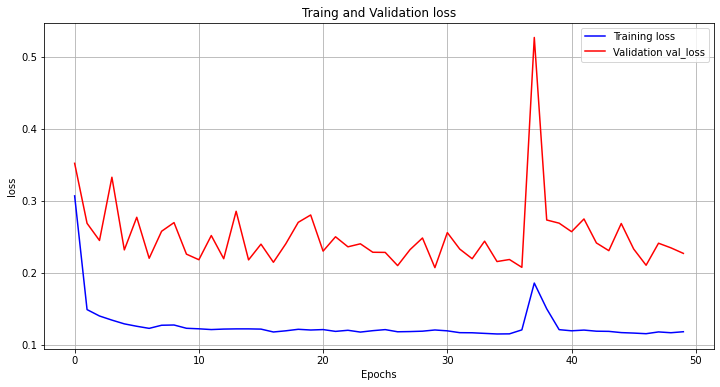

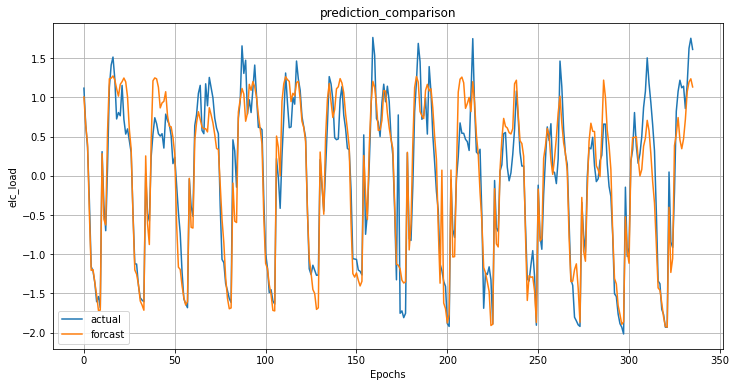

In [47]:
if __name__ == '__main__':
    main()